# Automate sentiment analysis of textual comments

Author: R Sruthi Parvatha 
Date: 5/09/20

# INTRODUCTION

Sentiment analysis (or opinion mining) uses natural language processing and machine learning to interpret and classify emotions in subjective data. Here, sentiment analysis is performed to understand the sentiments of tweets of US Airlines. It is very important analytics used by businesses to receive constructive feedback.

1) Import Modules

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import collections
from pprint import pprint

sns.set(style="whitegrid", context="paper", font_scale=2.0)

In [2]:
np.random.seed(37)

In [3]:
#Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

Here, the dataset is shuffled in case it was sorted, by  permutation of original indices and reindexing them. Required dataset contains only two fields namely text and class variables.

In [4]:
#Data PreProcessing
df = pd.read_csv('Tweets.csv')
airlines_train = df.reindex(np.random.permutation(df.index))

#only the text and the sentiment of the tweet is sufficient for the model
airlines_train = airlines_train[['text','airline_sentiment']]
print(airlines_train.head())

                                                    text airline_sentiment
10620  @USAirways told to work it out ourselves #joke...          negative
13609  @AmericanAir that all AA is for USAir Elite me...          negative
2955   @united Bummer. Might have to go with @America...          negative
3585   @united well the income flight to dca to take ...          negative
2087   @united we have tried to change our flight THR...          negative


Through exploratory data analysis we gather that, the dataset is imbalanced. Any tweet's sentiment can be classified into one of these three classes namely positive, negative or neutral.

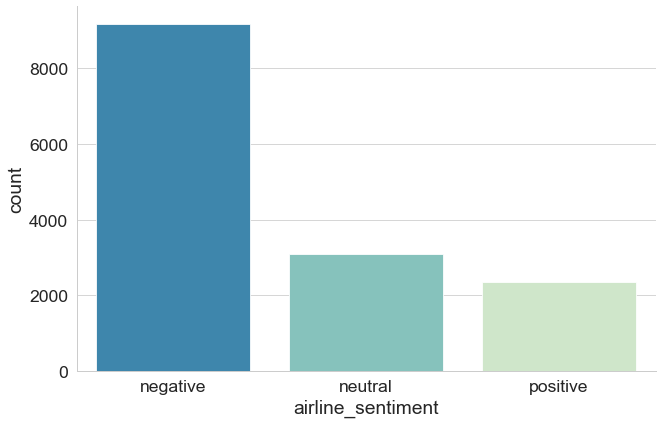

In [5]:
sns.factorplot(x="airline_sentiment", data=airlines_train, kind="count",size=6, aspect=1.5, palette="GnBu_r");
plt.show()

Analysing the tweet/text variable:
Create a class TextCounts that computes some basic statistics on the text variable.

count_words : number of words in atweet
count_mentions : referrals to other accounts commonly preceded by a @
count_hashtags : number of tag words, preceded by a #
count_capital_words : number of uppercase words commonly used to express (negative) emotions
count_excl_quest_marks : number of question/exclamation marks
count_urls : number of links in a tweet, usually preceded by http(s)

In [6]:
# Some basic statistics on the Text Variable
import emoji
from pprint import pprint
from sklearn.base import BaseEstimator, TransformerMixin

class TextCounts(BaseEstimator, TransformerMixin):
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    def fit(self,X,y=None, **fit_params):
#         this method is used to fit when specific operations need to be performed on training data but not on test data
        return self
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x))
        
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+',x))
        
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+',x))
        
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b',x))
        
        count_exclaim_question_marks = X.apply(lambda x: self.count_regex(r'!|\?',x))
        
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?',x))
        
        airlines_train = pd.DataFrame({'count_words':count_words,
                                      'count_mentions':count_mentions,
                                      'count_hashtags': count_hashtags,
                                      'count_capital_words': count_capital_words,
                                      'count_exclaim_question_marks': count_exclaim_question_marks,
                                      'count_urls': count_urls
                                      })
        
        return airlines_train
    
        
        

In [7]:
tc = TextCounts()
airlines_train_eda =  tc.fit_transform(airlines_train.text)
#Add airline_sentiment to airlines_data_eda
airlines_train_eda['airline_sentiment'] = airlines_train.airline_sentiment


Plot per target class and descriptive statistics

In [8]:
# Visualizing how the TextCount variables relate to the classs variables
def show_dist(df, col):
    print('Descriptive statistics for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max()+1)
    g = sns.FacetGrid(df, col='airline_sentiment', size=6, hue='airline_sentiment', palette = "GnBu_r")
    g = g.map(sns.distplot, col, kde = False, norm_hist=True, bins = bins)
    plt.show()
    



Descriptive statistics for count_mentions
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  1.111244  0.365420  1.0  1.0  1.0  1.0  6.0
neutral            3099.0  1.167473  0.480102  1.0  1.0  1.0  1.0  5.0
positive           2363.0  1.138383  0.432462  1.0  1.0  1.0  1.0  6.0


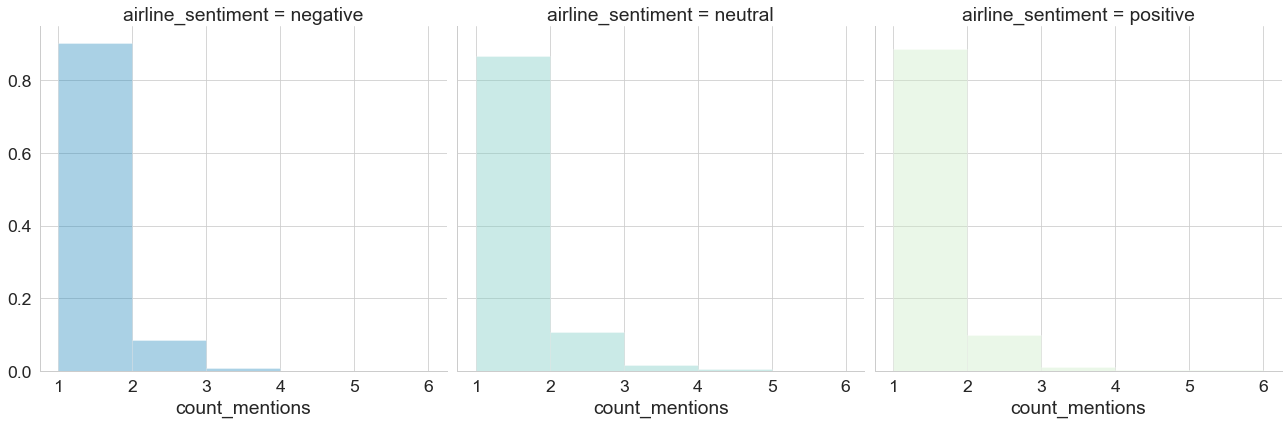

In [9]:
show_dist(airlines_train_eda,'count_mentions')

Descriptive statistics for count_hashtags
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  0.233384  0.615099  0.0  0.0  0.0  0.0  6.0
neutral            3099.0  0.212004  0.666382  0.0  0.0  0.0  0.0  6.0
positive           2363.0  0.297503  0.774776  0.0  0.0  0.0  0.0  8.0


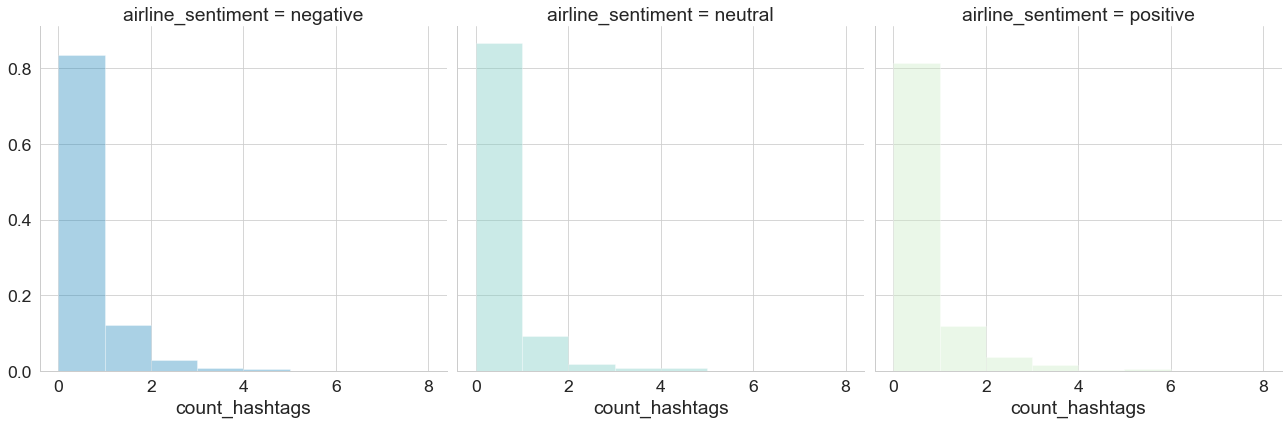

In [10]:
show_dist(airlines_train_eda,'count_hashtags')

Descriptive statistics for count_capital_words
-----------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.429070  1.019710  0.0  0.0  0.0  1.0  22.0
neutral            3099.0  0.462085  0.939468  0.0  0.0  0.0  1.0  11.0
positive           2363.0  0.461278  1.234078  0.0  0.0  0.0  1.0  20.0


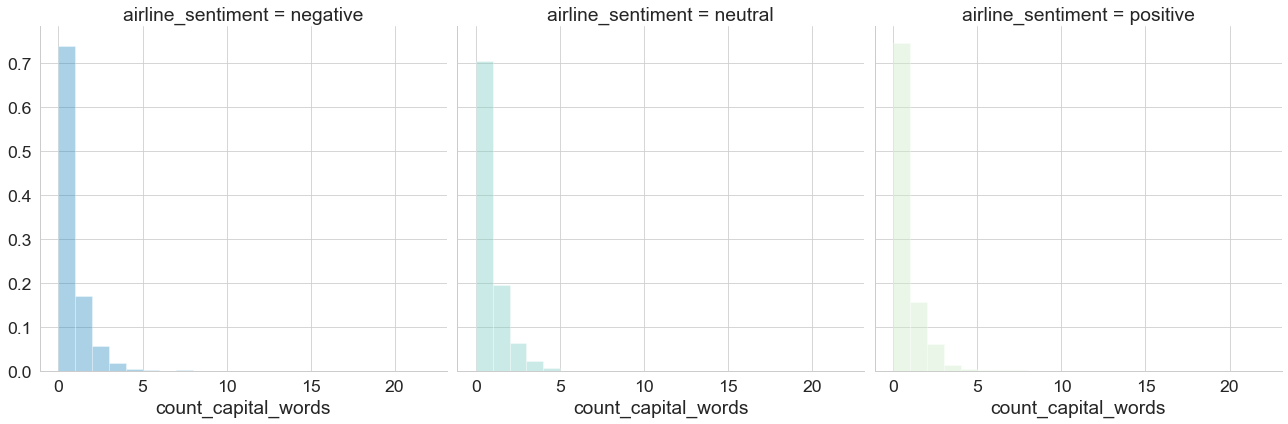

In [11]:
show_dist(airlines_train_eda,'count_capital_words')

Descriptive statistics for count_exclaim_question_marks
--------------------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.634125  1.143958  0.0  0.0  0.0  1.0  27.0
neutral            3099.0  0.665053  0.928761  0.0  0.0  0.0  1.0  12.0
positive           2363.0  0.892510  1.199191  0.0  0.0  1.0  1.0  13.0


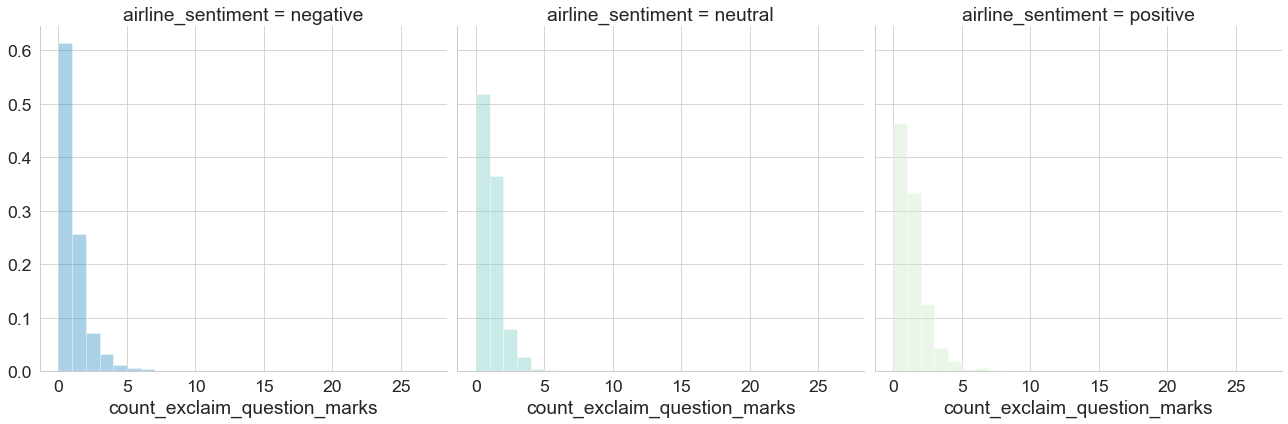

In [12]:
show_dist(airlines_train_eda,'count_exclaim_question_marks')

Descriptive statistics for count_urls
--------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  0.049248  0.218403  0.0  0.0  0.0  0.0  2.0
neutral            3099.0  0.169732  0.401225  0.0  0.0  0.0  0.0  3.0
positive           2363.0  0.098603  0.303818  0.0  0.0  0.0  0.0  2.0


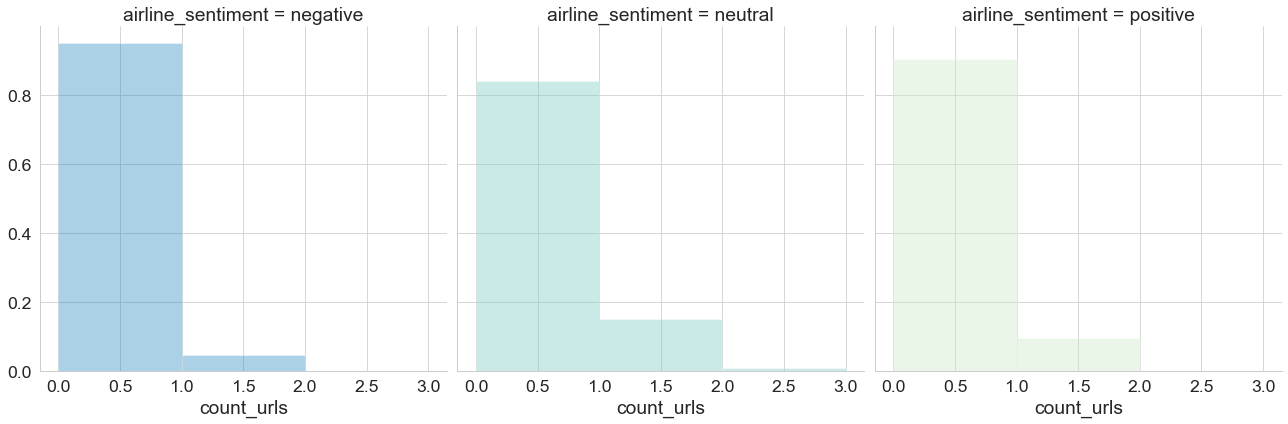

In [13]:
show_dist(airlines_train_eda,'count_urls')

CONCLUSIONS:

Low Rate of The number of words used in the tweets. Max and min number of words in tweet are 36 words and 2 words respectively.
Neutral or positive tweets contain lesser words than Negative tweets.
All tweets have at least one mention. No dependence between the sentiment and the no. of mentions.
The positive tweets are most likely to use exclamation/question marks.
Most tweets do not contain a URL,emojis,hash tags or capitalized words. Also there is no effect of sentiment of the tweets on the prior mentioned factors.
Thus, they are essentially independent of each other.


# Cleaning tweets/text

Before building the model, tweets need to be cleaned as in:
1) Removing mentions(@), urls(http(s)), punctuations, digits etc.
2) Replacing emojis with a single character
3) Converting all text to lowercase
4) Removing stopwords, which are commonly used words like 'a','the' that do not contribute to the meaning or sentiment of the text.
5) Apply PorterStemmer to retain the stem of the words. For instance the stem of the word eating, eaten, eats is the word eat.

In [14]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [15]:
# Sample of cleaned text
ct = CleanText()
sr_clean = ct.fit_transform(airlines_train.text)
sr_clean.sample(5)


12222             glad rt bet bird wish flown south winter
3936     point upc code check baggag tell luggag vacat ...
367                     vx jfk la dirti plane not standard
12257    tell mean work need estim time arriv pleas nee...
2957     sure busi go els airlin travel name kathryn so...
Name: text, dtype: object

In [16]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

22 records have no words left after text cleaning


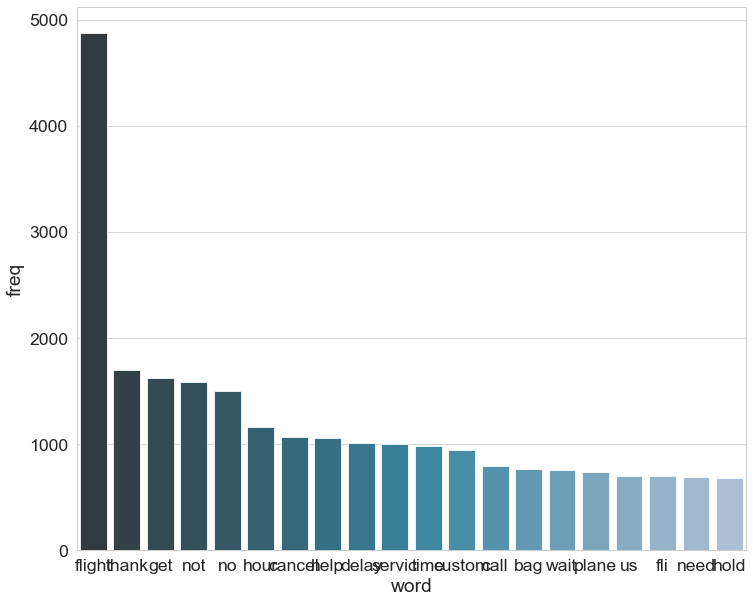

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

CONCLUSION: Flight is the most frequently used word in this dataset.

# Creating test data

In [18]:
df_model = airlines_train_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_exclaim_question_marks',
 'count_urls',
 'airline_sentiment',
 'clean_text']

used in Pipeline later on

In [19]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

# Splitting into train and test datasets

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.1, random_state=37)

# Hyperparameter tuning and cross-validation

In order to obtain a model with high accuracy we make use of the concept of cross-validation wherein the dataset is split into train and test datasets multiple times, into validation sets and the average accuracy of all models is taken for measuring performance.Pipeline is created in order to find the best parameters for both a vectorizer and classifier.

Evaluation metrics
By default GridSearchCV uses the default scorer to compute the bestscore. For both the MultiNomialNb and LogisticRegression this default scoring metric is the accuracy.

Classification Report contains the following metrics:
Precision: No of rows correctly predicted from the predictions
            the ratio of true positives to the sum of a true positive and false positive.
Recall: Of all rows of a certain class, how many did we correctly predict?
        ratio of true positives to the sum of true positives and false negatives.
F1 score: What percent of positive predictions were correct?
           Harmonic mean of Precision and Recall.

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from time import time
import os
from sklearn.externals import joblib

def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_exclaim_question_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

C:\Users\91807\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Parameter grids for GridSearchCV

In [22]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

# Classifier

In [23]:
#Classifiers
from sklearn.naive_bayes import MultinomialNB
mnomNB = MultinomialNB()

CountVectorizer converts the words to a number in the classifier. Moreover it counts the frequency of the word per tweet as well. This returns a bag of words which is an example of sparse dataset as most records have many zeros for words not occuring in the tweet.

In [24]:
countvect = CountVectorizer()

In [25]:
# MultinomialNB
best_mnb_countvect = grid_vect(mnomNB, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   29.3s finished


done in 31.020s

Best CV score: 0.776
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.784


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.81      0.91      0.86       911
     neutral       0.67      0.48      0.56       320
    positive       0.78      0.71      0.74       233

    accuracy                           0.78      1464
   macro avg       0.75      0.70      0.72      1464
weighted avg       0.77      0.78      0.77      1464



CONCLUSION:
Accuracy using CountVectorizer is 78%.
Precision is highest for detecting negative sentiment using this model.

# TF-IDF(Term Frequency - Inverse Frequency Document Frequency)

One issue with CountVectorizer is that there might be words that occur frequently in observations of the target classes. These words do not have discriminatory information and can be removed.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvect = TfidfVectorizer()

In [27]:
# MultinomialNB
best_mnb_tfidf = grid_vect(mnomNB, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   21.0s finished


done in 22.522s

Best CV score: 0.750
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.750


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.74      0.97      0.84       911
     neutral       0.76      0.29      0.42       320
    positive       0.82      0.50      0.62       233

    accuracy                           0.75      1464
   macro avg       0.77      0.59      0.63      1464
weighted avg       0.76      0.75      0.72      1464



CONCLUSION:
Accuracy using TF-IDF Classifier is 75%.
Precision is highest for detecting positive sentiment using this model.

Future Scope:
Can perform Sentiment Analyis for the same dataset using Word2Vec algorithm implemented in gensim package.
Word2Vec maps each word in a multi-dimensional space. It does this by taking into account the context in which a word appears in the tweets. 
As a result, words that are semantically similar are also close to each other in the multi-dimensional space.

Lastly, Logistic Regression Classifier too is a viable option in place of Naive Bayes Classifier for performing Sentiment Analysis.
